# Progetto di social computing 2025
### Analisi di dataset di scopus


## Analisi dataset


In [5]:
import pandas as pd
import networkx as nx
import json
from networkx.readwrite import json_graph
from itertools import combinations

# =========================
# Carica dataset
# =========================
df = pd.read_csv("../data/nuovo_dataset.csv")

# Rimuovi righe senza autori o anno
df = df.dropna(subset=['Author full names', 'Year'])

# =========================
# Crea grafi per anno
# =========================
grafi_per_anno = {}

for anno in df['Year'].unique():
    G = nx.Graph()
    df_anno = df[df['Year'] == anno]

    for authors_str in df_anno['Author full names']:
        authors = [a.strip() for a in authors_str.split(';')]
        # crea arco tra ogni coppia di autori
        for u, v in combinations(authors, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)
    grafi_per_anno[anno] = G

print("Grafi creati per anno:", list(grafi_per_anno.keys()))

# =========================
# Dizionari per risultati
# =========================
central_node_per_anno = {}
highlight_nodes_per_anno = {}
subgrafi_per_anno = {}
pos_per_anno = {}

# =========================
# Nodo centrale, sottografi e serializzazione JSON
# =========================
for anno, G in grafi_per_anno.items():
    if len(G) == 0:
        continue

    # Nodo centrale (grado massimo)
    central = max(G.degree, key=lambda x: x[1])[0]
    central_node_per_anno[anno] = central

    # Vicini equicentrali
    central_degree = G.degree(central)
    equicentral_neighbors = [
        n for n in G.neighbors(central)
        if G.degree(n) == central_degree
    ]
    highlight_nodes_per_anno[anno] = [central] + equicentral_neighbors

    # Sottografo centrale + vicini
    neighbors = list(G.neighbors(central))
    nodes = [central] + neighbors
    H = G.subgraph(nodes).copy()
    subgrafi_per_anno[anno] = H

    # Posizioni
    initial_pos = {central: (0, 0)}
    pos = nx.spring_layout(H, seed=42, pos=initial_pos, fixed=[central])
    pos_per_anno[anno] = pos

    # Serializzazione JSON
    data_json = json_graph.node_link_data(H)
    filename = f"../graphs/subgrafo_{anno}.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data_json, f, ensure_ascii=False, indent=2)

print("Serializzazione dei sottografi completata!")


FileNotFoundError: [Errno 2] No such file or directory: '../data/nuovo_dataset.csv'

In [ ]:
df.columns

Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'References', 'Correspondence Address', 'Publisher',
       'ISSN', 'Abbreviated Source Title', 'Document Type',
       'Publication Stage', 'EID'],
      dtype='object')

In [ ]:
grafi_unico_json = {}

for anno in df['Year'].unique():
    G = nx.Graph()
    df_anno = df[df['Year'] == anno]

    for authors_str in df_anno['Author full names']:
        authors = [a.strip() for a in authors_str.split(';')]
        for u, v in combinations(authors, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)

    if len(G) > 0:
        central = max(G.degree, key=lambda x: x[1])[0]
        central_degree = G.degree(central)
        equicentral_neighbors = [
            n for n in G.neighbors(central)
            if G.degree(n) == central_degree
        ]
        nodes = [central] + equicentral_neighbors
        H = G.subgraph(nodes).copy()
    else:
        H = G

    # ✅ Chiave convertita in stringa
    grafi_unico_json[str(anno)] = json_graph.node_link_data(H)

# Salva in un unico JSON
with open("../graphs/grafi_tutti.json", "w", encoding="utf-8") as f:
    json.dump(grafi_unico_json, f, ensure_ascii=False, indent=2)

print("Tutti i sottografi salvati in un unico file: grafi_tutti.json")


Tutti i sottografi salvati in un unico file: grafi_tutti.json


In [ ]:
import json
from networkx.readwrite import json_graph
import networkx as nx

# Carica JSON
with open("../graphs/grafi_tutti.json", "r", encoding="utf-8") as f:
    dati = json.load(f)

# Esempio: ricostruire il grafo del 2020
G2020 = json_graph.node_link_graph(dati["2020"])
print(G2020.nodes(), G2020.edges())


['Gigli, Gian Luigi (7101781977)'] []


# INIZIO

LISTA AUTORI BELLA

In [ ]:
df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a)  # rimuove (ID)
        .replace(",", "")               # rimuove virgole
        .strip()
        for a in authors
    ])
)
df["authors_list"]

NameError: name 'df' is not defined

Grafi per anno

In [ ]:
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
grafi_per_anno = {}
for anno, df_anno in df.groupby("Year"):
    G = nx.Graph()
    for authors in df_anno["authors_list"].dropna():
        for a1, a2 in itertools.combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)
    grafi_per_anno[anno] = G

CENTRALITA'...

In [28]:
import pandas as pd
import networkx as nx
import re

# 1. Caricamento dataset
df = pd.read_csv("nuovo_dataset.csv")
df = df.dropna(subset=["Author full names"])

# 2. Pulizia autori con la tua modalità specifica
df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a)  # rimuove (ID)
        .replace(",", "")               # rimuove virgole
        .strip()
        for a in authors
    ])
)

# 3. Costruzione del Grafo di Co-autoria
G = nx.Graph()

for authors in df["authors_list"]:
    if len(authors) > 1:
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                if G.has_edge(authors[i], authors[j]):
                    G[authors[i]][authors[j]]['weight'] += 1
                else:
                    G.add_edge(authors[i], authors[j], weight=1)
    elif len(authors) == 1:
        G.add_node(authors[0])


# Degree Centrality (Numero di collaboratori diversi)
degree_cent = nx.degree_centrality(G)

# Betweenness Centrality (Capacità di fare da ponte)
betweenness_cent = nx.betweenness_centrality(G)

# Closeness Centrality (Vicinanza media a tutti gli altri nodi)
closeness_cent = nx.closeness_centrality(G)

# 5. Organizzazione in DataFrame
risultati = pd.DataFrame({
    'Autore': list(degree_cent.keys()),
    'Degree': list(degree_cent.values()),
    'Betweenness': [betweenness_cent[a] for a in degree_cent.keys()],
    'Closeness': [closeness_cent[a] for a in degree_cent.keys()]
})

# 6. Output Top 10
def stampa_top(df, colonna, titolo):
    print("\n" + "="*60)
    print(f"{titolo:^60}")
    print("="*60)
    print(df.sort_values(by=colonna, ascending=False).head(10)[['Autore', colonna]].to_string(index=False))

stampa_top(risultati, 'Degree', 'TOP 10 AUTORI PER DEGREE CENTRALITY')
stampa_top(risultati, 'Betweenness', 'TOP 10 AUTORI PER BETWEENNESS CENTRALITY')
stampa_top(risultati, 'Closeness', 'TOP 10 AUTORI PER CLOSENESS CENTRALITY')


            TOP 10 AUTORI PER DEGREE CENTRALITY             
                           Autore   Degree
                 Gigli Gian Luigi 0.330556
             Valente Mariarosaria 0.283333
                Bernardini Andrea 0.169444
                  Plazzi Giuseppe 0.141667
                    Abril Beatriz 0.141667
           Trenkwalder Claudia M. 0.141667
          Sixel-Döring Friederike 0.141667
                 Heidbreder A. E. 0.141667
        Charley-Monaca Christelle 0.141667
Puligheddu Monica Maria Francesca 0.141667

          TOP 10 AUTORI PER BETWEENNESS CENTRALITY          
              Autore  Betweenness
   Fogolari Federico     0.246549
    Gigli Gian Luigi     0.210439
     Giannozzi Paolo     0.156175
        Esseni David     0.076292
    Curcio Francesco     0.073518
     Dovier Agostino     0.064753
   Driussi Francesco     0.060655
    Antonelli Matias     0.042792
   Foresti Gian Luca     0.039209
Valente Mariarosaria     0.036772

           TOP 10 AUTORI PER

In [30]:
import pandas as pd
import networkx as nx
import re

# --- CARICAMENTO E PREPARAZIONE ---
df = pd.read_csv("nuovo_dataset.csv")
df = df.dropna(subset=["Author full names"])

df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a) 
        .replace(",", "")
        .strip()
        for a in authors
    ])
)

G = nx.Graph()
for authors in df["authors_list"]:
    if len(authors) > 1:
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                if G.has_edge(authors[i], authors[j]):
                    G[authors[i]][authors[j]]['weight'] += 1
                else:
                    G.add_edge(authors[i], authors[j], weight=1)
    elif len(authors) == 1:
        G.add_node(authors[0])

degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)  # <--- AGGIUNTO

risultati = pd.DataFrame({
    'Autore': list(degree_cent.keys()),
    'Degree': list(degree_cent.values()),
    'Betweenness': [betweenness_cent[a] for a in degree_cent.keys()],
    'Closeness': [closeness_cent[a] for a in degree_cent.keys()] # <--- AGGIUNTO
})

# =================================================================
# FUNZIONE AGGIORNATA PER IL "CENTRAL AUTHOR"
# =================================================================

def get_top_degree_author_details(df_risultati):
    """
    Identifica l'autore con la Degree Centrality più alta 
    e restituisce i suoi valori completi.
    """
    # Ordiniamo per Degree e prendiamo il primo
    top_author_row = df_risultati.sort_values(by='Degree', ascending=False).iloc[0]
    
    return (
        top_author_row['Autore'], 
        top_author_row['Degree'], 
        top_author_row['Betweenness'],
        top_author_row['Closeness'] # <--- AGGIUNTO
    )

# Esecuzione della funzione
central_author, d_val, b_val, c_val = get_top_degree_author_details(risultati)

print("\n" + "="*60)
print(f"🥇 AUTORE PIÙ CENTRALE (Top Degree)")
print("="*60)
print(f"Nome:        {central_author}")
print(f"Degree:      {d_val:.4f} (Top 1)")
print(f"Betweenness: {b_val:.4f} (Top 2)")
print(f"Closeness:   {c_val:.4f} (Top 1)")
print("="*60)


🥇 AUTORE PIÙ CENTRALE (Top Degree)
Nome:        Gigli Gian Luigi
Degree:      0.3306 (Top 1)
Betweenness: 0.2104 (Top 2)
Closeness:   0.3119 (Top 1)


# GRAFI


GRAFO 1


In [6]:
# =========================
# Nodo centrale per anno
# =========================
central_node_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) == 0:
        continue
    central_node_per_anno[anno] = max(G.degree, key=lambda x: x[1])[0]

# =========================
# Vicini equicentrali del nodo centrale
# =========================
highlight_nodes_per_anno = {}
for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    central_degree = G.degree(central)
    equicentral_neighbors = [
        n for n in G.neighbors(central)
        if G.degree(n) == central_degree
    ]
    highlight_nodes_per_anno[anno] = [central] + equicentral_neighbors

# =========================
# Sottografo: centrale + vicini
# =========================
subgrafi_per_anno = {}
pos_per_anno = {}

for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    neighbors = list(G.neighbors(central))
    nodes = [central] + neighbors
    H = G.subgraph(nodes).copy()
    subgrafi_per_anno[anno] = H

    initial_pos = {central: (0, 0)}
    pos = nx.spring_layout(H, seed=42, pos=initial_pos, fixed=[central])
    pos_per_anno[anno] = pos

# =========================
# Funzione Plotly
# =========================
def plot_graph_plotly(G, pos, highlight_nodes):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        showlegend=False
    )

    node_x, node_y, texts, colors, sizes = [], [], [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Grado: {G.degree(node)}")

        if node in highlight_nodes:
            colors.append("crimson")
            sizes.append(11)
        else:
            colors.append("royalblue")
            sizes.append(8)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        text=texts,
        hoverinfo="text",
        marker=dict(
            size=sizes,
            color=colors,
            line=dict(width=0.5, color="black")
        ),
        showlegend=False
    )

    return edge_trace, node_trace

# =========================
# Genera titoli subplot
# =========================
authors_per_anno = {}
for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    central_degree = G.degree(central)
    equicentral_neighbors = [
        n for n in G.neighbors(central)
        if G.degree(n) == central_degree
    ]
    all_authors = [central] + equicentral_neighbors
    authors_per_anno[anno] = all_authors


anni = sorted(grafi_per_anno.keys())


titoli = []
for anno in anni:
    authors = authors_per_anno.get(anno, [])
    # massimo 3 autori
    if len(authors) > 3:
        authors = authors[:3] + ["..."]
    # raggruppa ogni 2 autori per riga
    lines = []
    for i in range(0, len(authors), 2):
        lines.append(", ".join(authors[i:i+2]))
    titolo = f"{anno}<br>" + "<br>".join(lines)
    titoli.append(titolo)

# =========================
# Crea figura 2x5
# =========================
fig = make_subplots(
    rows=2, cols=5,
    subplot_titles=titoli,
    horizontal_spacing=0.03,
    vertical_spacing=0.08
)

for i, anno in enumerate(anni):
    if anno not in subgrafi_per_anno:
        continue
    G = subgrafi_per_anno[anno]
    pos = pos_per_anno[anno]
    highlight_nodes = highlight_nodes_per_anno[anno]

    edge, node = plot_graph_plotly(G, pos, highlight_nodes)

    row = 1 if i < 5 else 2
    col = i + 1 if i < 5 else i - 4

    fig.add_trace(edge, row=row, col=col)
    fig.add_trace(node, row=row, col=col)

# =========================
# Layout finale
# =========================
fig.update_layout(
    height=650,
    width=1400,
    paper_bgcolor="white",
    plot_bgcolor="white",
    title_x=0.5,
    font=dict(size=10),
    margin=dict(l=20, r=20, t=50, b=20)
)

for r in [1, 2]:
    for c in range(1, 6):
        fig.update_xaxes(visible=False, row=r, col=c)  
        fig.update_yaxes(visible=False, row=r, col=c)  

fig.update_layout(
    margin=dict(t=50, b=20, l=20, r=20),
)

for ann in fig.layout.annotations:
    ann.font = dict(size=12)

fig.show()


NameError: name 'grafi_per_anno' is not defined

GRAFO 2

In [7]:
# ==============================
# Grafo totale e autore centrale globale
# ==============================
G_totale = nx.compose_all(grafi_per_anno.values())
central_author = max(G_totale.degree, key=lambda x: x[1])[0]
print("Autore centrale globale:", central_author)

# ==============================
# Creazione grafi cumulativi
# ==============================
grafi_cumulativi = {}
G_cumulativo = nx.Graph()

for anno in sorted(grafi_per_anno.keys()):
    G_cumulativo = nx.compose(G_cumulativo, grafi_per_anno[anno])
    grafi_cumulativi[anno] = G_cumulativo.copy()

# ==============================
# Calcolo layout per anno
# ==============================
pos_per_anno = {}
for anno, G in grafi_cumulativi.items():
    if central_author not in G:
        continue

    nodes_connected = nx.node_connected_component(G, central_author)
    G_sub = G.subgraph(nodes_connected).copy()

    initial_pos = {central_author: (0, 0)}

    pos = nx.spring_layout(
        G_sub,
        seed=42,
        pos=initial_pos,
        fixed=[central_author],
        k=0.5,
        iterations=200
    )

    xs = [x for x, y in pos.values()]
    ys = [y for x, y in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    for node in pos:
        x, y = pos[node]
        norm_x = -1.1 + 2.2 * (x - min_x) / (max_x - min_x) if max_x > min_x else 0
        norm_y = -1.1 + 2.2 * (y - min_y) / (max_y - min_y) if max_y > min_y else 0
        pos[node] = (norm_x, norm_y)

    pos_per_anno[anno] = pos
    grafi_cumulativi[anno] = G_sub  

# ==============================
# Funzione di plotting
# ==============================
def plot_graph_plotly(G, pos, central_node):
    edge_x, edge_y = [], []

    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        name="Collaborazioni",
        showlegend=True
    )

    node_x, node_y, texts, colors, sizes = [], [], [], [], []

    for node in G.nodes():
        if node == central_node:
            continue
        x, y = pos[node]
        deg = G.degree(node)
        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Collaborazioni: {deg}")
        colors.append("royalblue")
        sizes.append(8)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=texts,
        marker=dict(
            size=sizes,
            color=colors,
            line=dict(width=0.5, color="black"),
            opacity=1.0
        ),
        name="Autori"
    )

    x_c, y_c = pos[central_node]
    node_central_trace = go.Scatter(
        x=[x_c],
        y=[y_c],
        mode="markers",
        hoverinfo="text",
        text=[f"{central_node}<br>Collaborazioni: {G.degree(central_node)}"],
        marker=dict(
            size=15,
            color="crimson",
            line=dict(width=0.5, color="black"),
            opacity=1.0
        ),
        name="Gigli G.L."
    )

    return edge_trace, node_trace, node_central_trace

# ==============================
# Creazione dei frame
# ==============================
frames = []

for anno in sorted(grafi_cumulativi.keys()):
    G = grafi_cumulativi[anno]
    if anno not in pos_per_anno: 
        continue
    pos = pos_per_anno[anno]
    edge, nodes, central = plot_graph_plotly(G, pos, central_author)
    frames.append(
        go.Frame(
            data=[edge, nodes, central],
            name=str(anno),
            layout=go.Layout(
                title=f"Collaborazioni cumulative fino al {anno}<br>Autore centrale: {central_author}"
            )
        )
    )


# ==============================
# Figura finale
# ==============================
fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(visible=False, range=[-1.5,1.5]),
        yaxis=dict(visible=False, range=[-1.5,1.5]),
        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {
                    "frame": {"duration":2000, "redraw":True},
                    "transition":{"duration":500},
                    "fromcurrent":True
                }]
            }]
        }],
        sliders=[{
            "steps": [{"method":"animate", "args":[[f.name]], "label":f.name} for f in frames]
        }]
    )
)

fig.show()


NameError: name 'grafi_per_anno' is not defined

GRAFO 3


In [12]:
import pandas as pd
from pyvis.network import Network
import json

def genera_grafo_statico(file_csv):
    try:
        # Caricamento del dataset fornito
        df = pd.read_csv(file_csv)
    except Exception as e:
        print(f"Errore nel caricamento del file: {e}")
        return

    # Calcolo frequenze e impatto citazioni dal dataset
    counts = df['Source title'].value_counts().to_dict()
    impact = df.groupby('Source title')['Cited by'].sum().to_dict() if 'Cited by' in df.columns else counts

    net = Network(height="900px", width="100%", bgcolor="#ffffff", font_color="black", select_menu=False)

    # Dizionario tematico tradotto e ottimizzato
    topic_mapping = {
        "Neuroscienze": {"color": "#9370db", "keywords": ["Brain", "Neuro", "Epileps", "Seizure", "Sleep", "Neurology", "Cerebellum", "Sclerosis"]},
        "Informatica e IA": {"color": "#97c2fc", "keywords": ["Computer", "Computing", "Software", "Logic", "Programming", "ACM", "Intelligence", "Automated Planning", "Heuristics"]},
        "Ingegneria e Segnali": {"color": "#40e0d0", "keywords": ["IEEE", "Signal", "Engineering", "Mechanical", "Electronics", "IMEKO", "Instruments", "Circuits", "Manufacturing", "Process Safety"]},
        "Scienze della Vita e Bio": {"color": "#ff69b4", "keywords": ["Bioinformatics", "Molecular", "Genetics", "Cancers", "Molecules", "Bio", "Nanoscale", "Thrombosis"]},
        "Matematica e Teoria": {"color": "#6a5acd", "keywords": ["Mathematics", "Matematica", "Algorithms", "Theory", "Calculus", "Formal", "Discrete", "Combinatorial", "Optimization"]},
        "Fisica": {"color": "#7be141", "keywords": ["Physics", "Nuclear", "Physical Review", "Frontiers in Physics"]},
        "Medicina Clinica": {"color": "#fb7e81", "keywords": ["Clinical", "Medicine", "Health", "Biomedica", "Acta Biomedica", "Expert Opinion"]},
        "Sostenibilità e Scienze Sociali": {"color": "#20b2aa", "keywords": ["Sustainability", "Education", "Science as Culture", "Transportation", "Social-Informatics"]},
        "Multidisciplinare": {"color": "#c0c0c0", "keywords": ["Scientific Reports", "Applied Sciences", "Nature", "MethodsX", "Proceedings of Science"]}
    }

    # Aggiunta Macro-aree (Dimensioni aumentate a 80)
    for topic, info in topic_mapping.items():
        net.add_node(topic, label=topic, color=info["color"], size=80, shape="ellipse")

    # Aggiunta Riviste dal dataset
    for title, freq in counts.items():
        if pd.isna(title): continue
        
        assigned_cats = []
        for topic, info in topic_mapping.items():
            for kw in info["keywords"]:
                if kw.lower() in str(title).lower():
                    assigned_cats.append(topic)
                    break
        
        if not assigned_cats: assigned_cats = ["Multidisciplinare"]

        primary_col = topic_mapping[assigned_cats[0]]["color"]
        imp_value = impact.get(title, 0)
        node_size = 15 + (min(imp_value, 50) / 2) if imp_value > 0 else 15
        
        net.add_node(title, label=title, shape="box", 
                     color={"border": primary_col, "background": "#ffffff"}, 
                     size=node_size)

        for cat in assigned_cats:
            net.add_edge(cat, title, value=freq, color=topic_mapping[cat]["color"])

    # CONFIGURAZIONE FISICA
    options = {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -150,
          "centralGravity": 0.01,
          "springLength": 200,
          "avoidOverlap": 1
        },
        "solver": "forceAtlas2Based",
        "stabilization": {
          "enabled": True,
          "iterations": 1000,
          "updateInterval": 25,
          "fit": True
        }
      },
      "nodes": {
        "borderWidth": 2
      },
      "interaction": {
        "dragNodes": True,
        "hover": True,
        "navigationButtons": True
      }
    }
    
    net.set_options(json.dumps(options))

    # Salvataggio file
    output_file = "grafo_statico.html"
    net.save_graph(output_file)

    # AGGIUNTA MANUALE DELLA LEGENDA HTML
    legenda_div = """
    <div style="position: fixed; top: 10px; right: 10px; width: 200px; padding: 10px; background-color: rgba(255,255,255,0.8); border: 1px solid #ccc; border-radius: 8px; z-index: 1000; font-family: Arial, sans-serif;">
        <h4 style="margin: 0 0 10px 0; font-size: 14px;">Legenda Aree</h4>
    """
    for topic, info in topic_mapping.items():
        legenda_div += f'<div style="display: flex; align-items: center; margin-bottom: 5px;"><div style="width: 12px; height: 12px; background-color: {info["color"]}; border-radius: 50%; margin-right: 8px;"></div><span style="font-size: 12px;">{topic}</span></div>'
    legenda_div += "</div>"

    with open(output_file, "r", encoding="utf-8") as f:
        html_content = f.read()

    # Inseriamo la legenda dopo il tag body
    html_content = html_content.replace('<body>', f'<body>{legenda_div}')

    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html_content)

    print("Grafo generato con successo")

# Esecuzione
genera_grafo_statico("nuovo_dataset.csv")

Grafo generato con successo


Analisi collaborazioni Udine - Italia - Estero

In [11]:
import pandas as pd
import re
from collections import Counter

# =====================================
# 1. CARICAMENTO E PULIZIA
# =====================================
df = pd.read_csv("nuovo_dataset.csv")
df = df.dropna(subset=["Affiliations"])

# 2. IDENTIFICAZIONE PAPER CON UDINE
df_udine = df[df["Affiliations"].str.contains("Udine", case=False, na=False)].copy()

# =====================================
# 3. PROCEDIMENTO DI CALCOLO
# =====================================
italy_counter = Counter()
foreign_counter = Counter()

# Fase A: Trova i nomi dei partner
for aff_string in df_udine["Affiliations"]:
    parts = [p.strip() for p in str(aff_string).split(";")]
    for p in parts:
        if "udine" in p.lower() or p == "": continue
        if "italy" in p.lower():
            italy_counter[p] += 1
        else:
            foreign_counter[p] += 1

# Fase B: Calcola i pesi (weight)
all_partners = list(italy_counter.keys()) + list(foreign_counter.keys())
partner_data = []

for p_name in all_partners:
    count = 0
    p_name_lower = p_name.lower()
    for row_aff in df_udine["Affiliations"]:
        if p_name_lower in str(row_aff).lower():
            count += 1
    
    if count >= 2: # Mantieni chi ha almeno 2 collaborazioni
        p_type = "Italian" if "italy" in p_name.lower() else "Foreign"
        partner_data.append({"Affiliation": p_name, "Type": p_type, "weight": count})

collab_counts = pd.DataFrame(partner_data)

# =====================================
# 4. FUNZIONE DI STAMPA (PULITA)
# =====================================
def print_left_aligned(df, title):
    print(f"\n{title}")
    if df.empty:
        print("Nessun dato trovato.")
        return
    df_str = df[['Affiliation', 'weight']].astype(str)
    widths = [max(df_str[col].str.len().max(), len(col)) for col in df_str.columns]
    header_row = "  ".join([col.ljust(widths[i]) for i, col in enumerate(df_str.columns)])
    print(header_row)
    print("-" * len(header_row))
    for _, row in df_str.iterrows():
        print("  ".join([row[col].ljust(widths[i]) for i, col in enumerate(df_str.columns)]))

# =====================================
# 5. OUTPUT FINALE (TOP 5)
# =====================================
top_italy = collab_counts[collab_counts["Type"]=="Italian"].sort_values(by="weight", ascending=False).head(5)
top_foreign = collab_counts[collab_counts["Type"]=="Foreign"].sort_values(by="weight", ascending=False).head(5)

print("CLASSIFICA TOP 5 COLLABORAZIONI TRA ITALIA ED ESTERO")
print_left_aligned(top_italy, "ITALIA:")
print_left_aligned(top_foreign, "ESTERO:")

CLASSIFICA TOP 5 COLLABORAZIONI TRA ITALIA ED ESTERO

ITALIA:
Affiliation                                                                                                weight
-----------------------------------------------------------------------------------------------------------------
Università degli Studi di Padova, Padua, PD, Italy                                                         8     
Università degli Studi di Trieste, Trieste, TS, Italy                                                      5     
Istituto Nazionale di Fisica Nucleare, Sezione di Trieste, Trieste, TS, Italy                              5     
Istituto Nazionale di Biostrutture e Biosistemi, Rome, RM, Italy                                           3     
Department of Medical Sciences and Public Health, Università degli Studi di Cagliari, Cagliari, CA, Italy  3     

ESTERO:
Affiliation                                                                                                                     wei

GRAFO 4

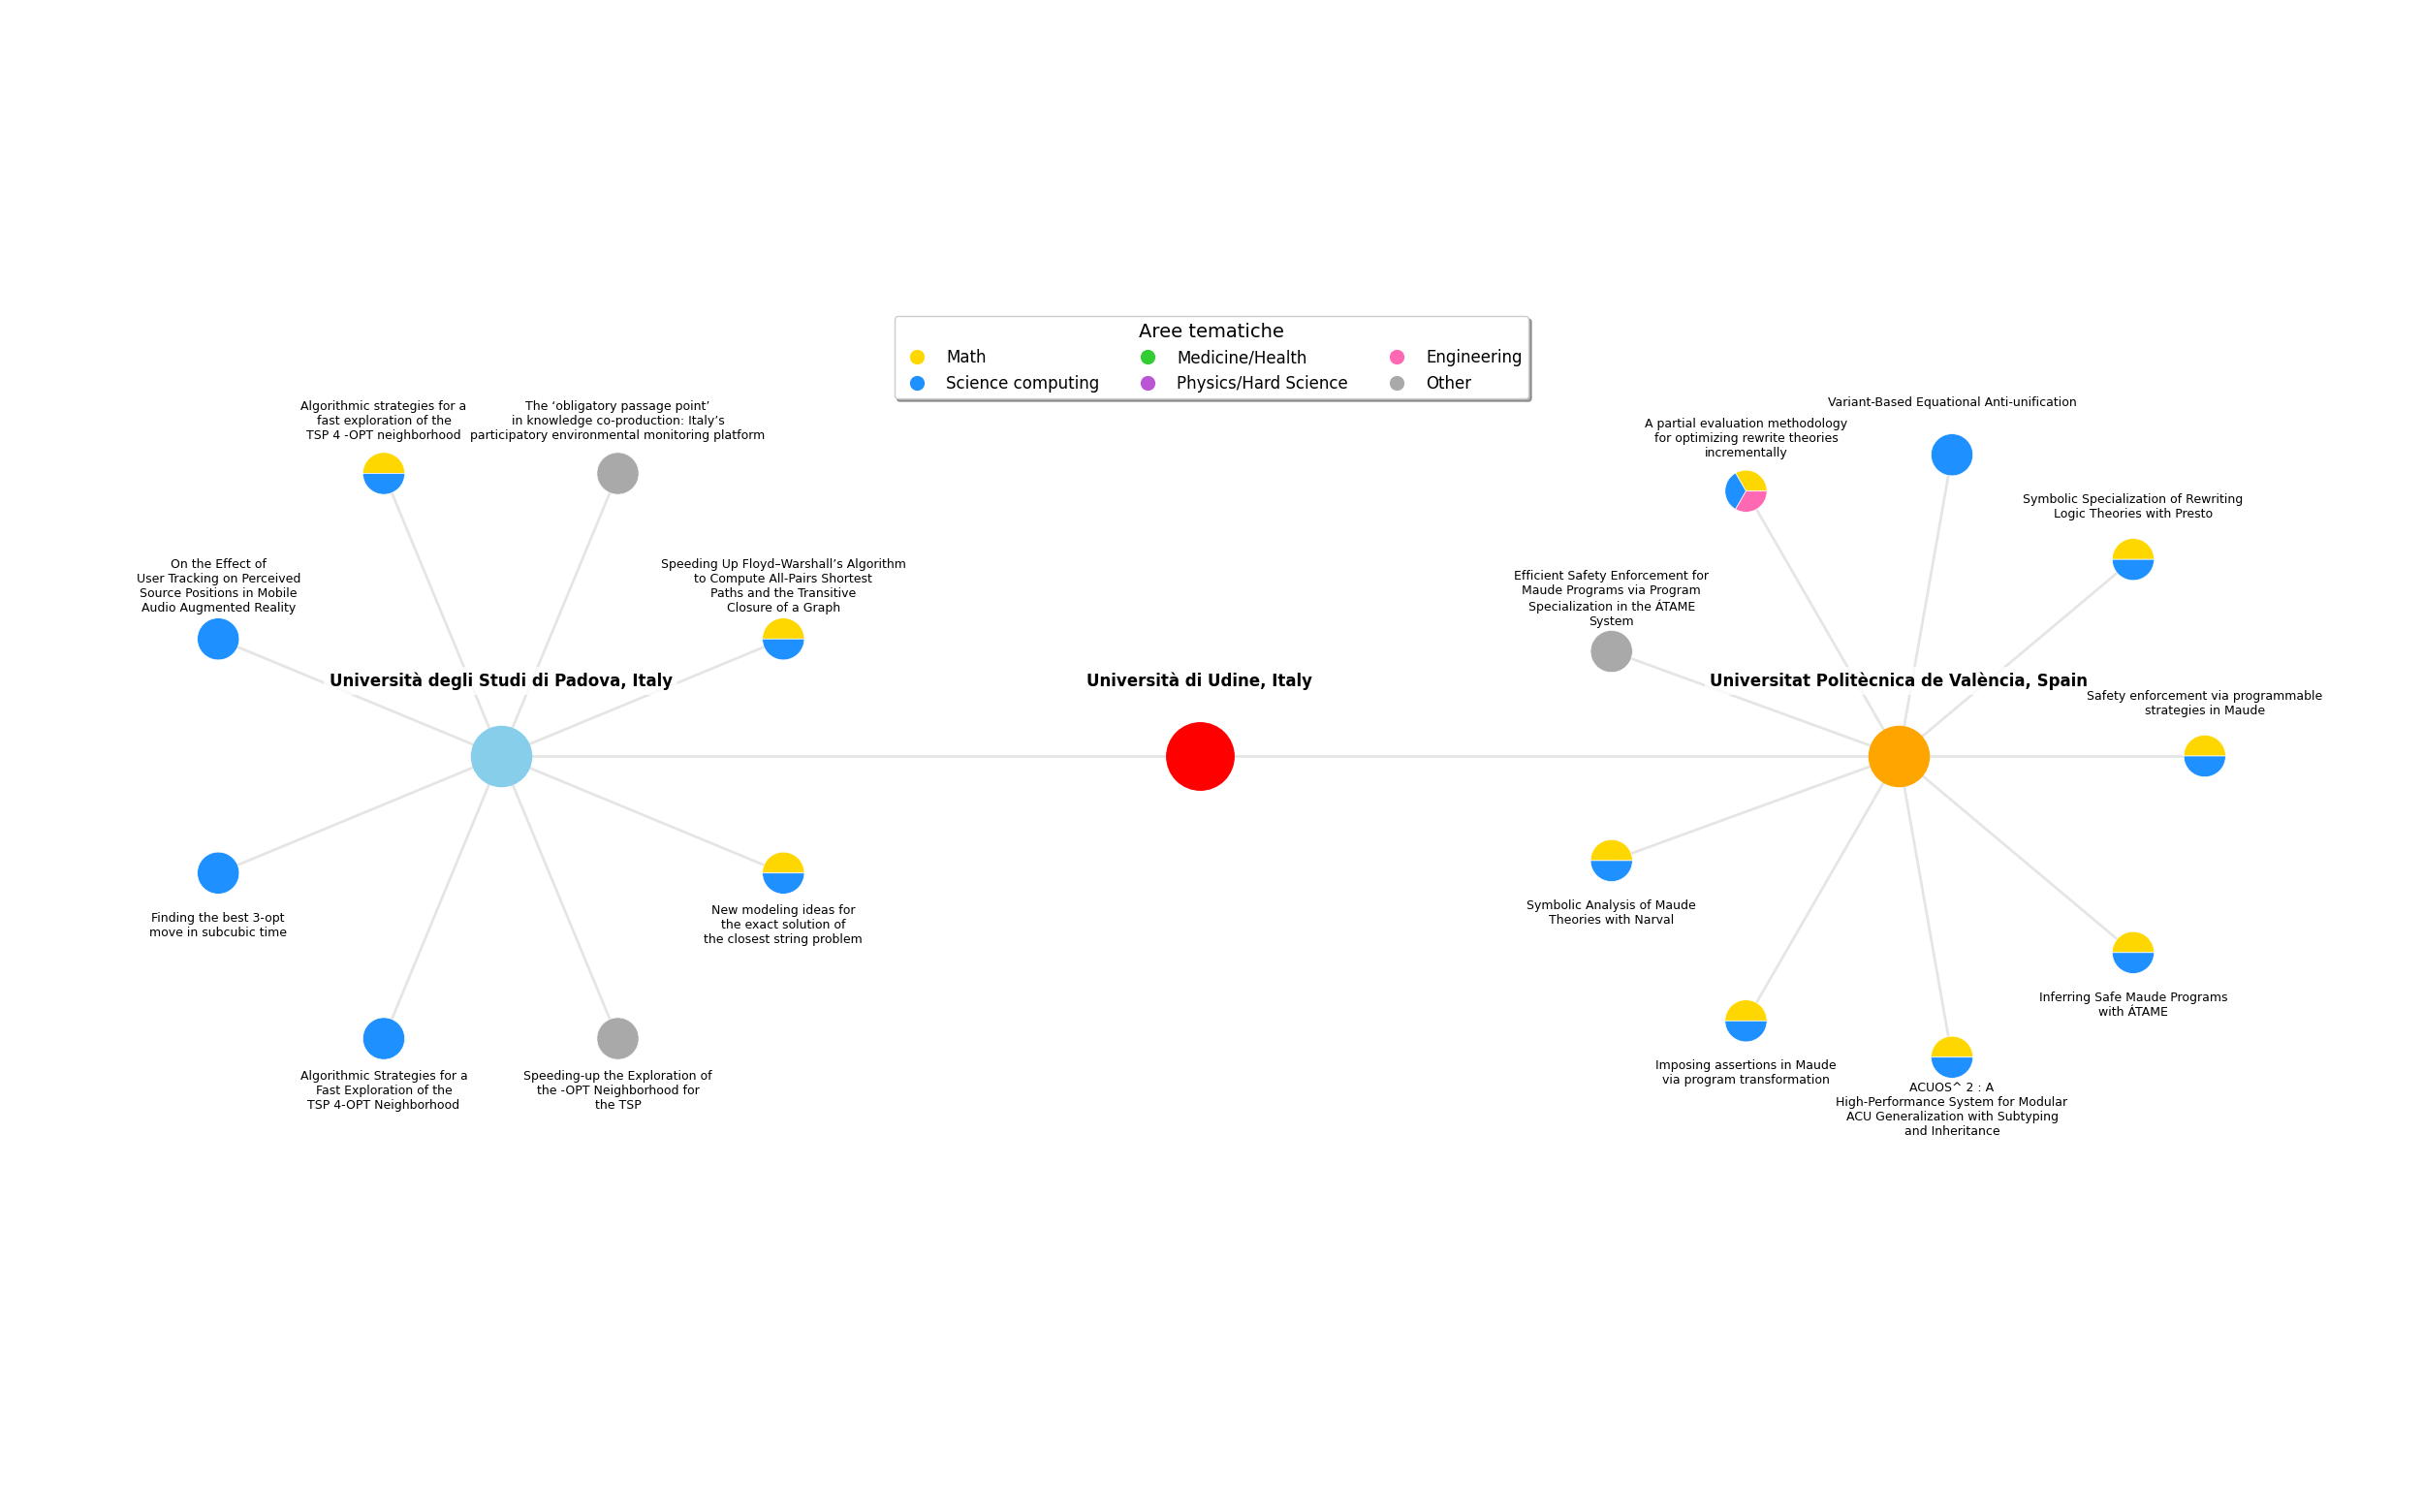

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.patches import Wedge

# --- 1️⃣ CARICAMENTO E ANALISI ---
df = pd.read_csv("nuovo_dataset.csv")
df_udine = df[df["Affiliations"].str.contains("Udine", case=False, na=False)].copy()

italy_counter = Counter()
foreign_counter = Counter()

def clean_uni_name(aff_string):
    parts = [p.strip() for p in aff_string.split(",")]
    if len(parts) >= 2:
        return f"{parts[0]}, {parts[-1]}"
    return aff_string

for aff_string in df_udine["Affiliations"]:
    affiliations = [a.strip() for a in aff_string.split(";")]
    for aff in affiliations:
        if "udine" in aff.lower(): continue
        if "italy" in aff.lower():
            italy_counter[aff] += 1
        else:
            foreign_counter[aff] += 1

raw_italy = italy_counter.most_common(1)[0][0]
raw_foreign = foreign_counter.most_common(1)[0][0]

uni_italy_clean = clean_uni_name(raw_italy)
uni_foreign_clean = clean_uni_name(raw_foreign)
udine_clean = "Università di Udine, Italy"

# --- 2️⃣ CONFIGURAZIONE CATEGORIE ---
categories_map = {
    "Math": ["math", "algebra", "logic", "discrete", "geometry", "analis", "matemat", "combinatorics", "graph theory", "set theory", "formal proofs", "optimization", "calculus", "numerical", "complexity"],
    "Science computing": ["computer", "algorithm", "informatic", "computing", "systems", "intelligence", "ai", "software", "data", "cyber", "heuristics", "ceur", "acm", "ieee", "machine learning", "deep learning", "neural net", "signal processing", "vision", "image", "cloud", "iot", "programming", "simulation"],
    "Medicine/Health": ["medicine", "neuro", "clinical", "drug", "health", "pharmac", "genet", "cancer", "bio", "oncology", "epilepsy", "sleep", "seizure", "cerebellum", "sclerosis", "thrombosis", "brain", "patient", "therapy", "medical"],
    "Physics/Hard Science": ["physic", "nuclear", "chemical", "chemistry", "nanoscale", "molecule", "material", "energy", "atoms", "mechanics", "astronomy", "scientific"],
    "Engineering": ["engineering", "mechanical", "electrical", "transportation", "manufacturing", "robotics", "control", "automation", "electronics", "sensors"]
}

color_palette = {
    "Math": "#FFD700", "Science computing": "#1E90FF", "Medicine/Health": "#32CD32",
    "Physics/Hard Science": "#BA55D3", "Engineering": "#FF69B4", "Other": "#A9A9A9"
}

# Set per tenere traccia delle categorie effettivamente usate

def get_article_categories(row):
    full_text = " ".join([str(row.get("Title", "")), str(row.get("Author Keywords", "")), str(row.get("Index Keywords", ""))]).lower()
    found = [cat for cat, keywords in categories_map.items() if any(kw in full_text for kw in keywords)]
    final_cats = found if found else ["Other"]
    return final_cats

def sanitize_title(title):
    if not isinstance(title, str): return ""
    for ch in ["$", "{", "}", "\\"]: title = title.replace(ch, "")
    title = title.replace("textsf", "").replace("mathbf", "")
    words = title.split()
    # Aumentiamo leggermente il numero di parole per riga per allargare il blocco di testo
    if len(words) > 4:
        lines = [" ".join(words[i:i+4]) for i in range(0, len(words), 4)]
        title = "\n".join(lines)
    return title.strip()

# --- 3️⃣ COSTRUZIONE GRAFO ---
G = nx.Graph()
G.add_edge(udine_clean, uni_italy_clean)
G.add_edge(udine_clean, uni_foreign_clean)

left, right, center = [], [], []
article_data = {}

for _, row in df_udine.iterrows():
    aff_lower = str(row["Affiliations"]).lower()
    title = sanitize_title(row["Title"])
    article_data[title] = get_article_categories(row)
    
    has_it = raw_italy.lower() in aff_lower
    has_fr = raw_foreign.lower() in aff_lower

    if has_it and not has_fr:
        left.append(title); G.add_edge(uni_italy_clean, title)
    elif has_fr and not has_it:
        right.append(title); G.add_edge(uni_foreign_clean, title)
    elif has_it and has_fr:
        center.append(title); G.add_edge(uni_italy_clean, title); G.add_edge(uni_foreign_clean, title)

# --- 4️⃣ LAYOUT ---
pos = {udine_clean: (0, 0), uni_italy_clean: (-8, 0), uni_foreign_clean: (8, 0)}

def arrange_full_circle(center_pos, items, radius):
    if not items: return
    # Slittamento di 22.5 gradi per i numeri pari
    start_offset = np.radians(22.5) if len(items) % 2 == 0 else 0
    angles = np.linspace(0, 2*np.pi, len(items), endpoint=False) + start_offset
    for i, t in enumerate(items):
        pos[t] = (center_pos[0] + radius * np.cos(angles[i]), 
                  center_pos[1] + radius * np.sin(angles[i]))

# Aumentato il raggio per dare più spazio ai testi larghi
arrange_full_circle(pos[uni_italy_clean], left, 3.5)
arrange_full_circle(pos[uni_foreign_clean], right, 3.5)
arrange_full_circle((0, -4.5), center, 2.5)

# --- 5️⃣ DISEGNO ---
plt.figure(figsize=(32, 20))
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')

nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="black", width=2)
nx.draw_networkx_nodes(G, pos, [udine_clean], node_color='red', node_size=2500)
nx.draw_networkx_nodes(G, pos, [uni_italy_clean], node_color='skyblue', node_size=2000)
nx.draw_networkx_nodes(G, pos, [uni_foreign_clean], node_color='orange', node_size=2000)

def draw_pie_node(center, categories, radius=0.25):
    n = len(categories)
    angle_per_slice = 360 / n
    for i, cat in enumerate(categories):
        w = Wedge(center, radius, i*angle_per_slice, (i+1)*angle_per_slice, 
                  facecolor=color_palette.get(cat, "#A9A9A9"), edgecolor='white', linewidth=0.5, zorder=3)
        ax.add_patch(w)

all_articles = left + right + center
for node in all_articles:
    draw_pie_node(pos[node], article_data[node], radius=0.24)

# Etichette Università
for n in [udine_clean, uni_italy_clean, uni_foreign_clean]:
    x, y = pos[n]
    plt.text(x, y + 0.8, s=n, fontsize=12, fontweight='bold', ha='center', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Etichette Articoli
for art in all_articles:
    x, y = pos[art]
    if art in left: cp = pos[uni_italy_clean]
    elif art in right: cp = pos[uni_foreign_clean]
    else: cp = (0, -4.5)
    
    # Offset maggiore per evitare che il testo largo tocchi il nodo
    offset_y = 0.60 if y >= cp[1] else -0.60
    plt.text(x, y + offset_y, s=art, fontsize=9, ha="center", va="center",
             bbox=dict(facecolor='white', alpha=0.85, edgecolor='none', pad=0.3))

# --- LEGENDA FILTRATA ---
# Creiamo gli elementi solo per le aree che compaiono nel set used_categories
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=k, 
           markerfacecolor=v, markersize=12) 
    for k, v in color_palette.items()
]

plt.legend(handles=legend_elements, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 0.80), 
           title="Aree tematiche", 
           fontsize=12, 
           title_fontsize=14,
           ncol=3,                    
           frameon=True, 
           shadow=True)

plt.axis("off")
plt.show()

GRAFO 5

In [25]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import re
from collections import Counter

# =========================================
# 1. CARICAMENTO E IDENTIFICAZIONE AUTORE
# =========================================
df = pd.read_csv("nuovo_dataset.csv")
df = df.dropna(subset=["Author full names"])

# Pulizia autori (Tua modalità specifica)
df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a).replace(",", "").strip()
        for a in authors
    ])
)

# Funzione per trovare l'autore con più collaborazioni
def get_central_author_data(df):
    G_temp = nx.Graph()
    for authors in df["authors_list"]:
        if len(authors) > 1:
            for i in range(len(authors)):
                for j in range(i + 1, len(authors)):
                    G_temp.add_edge(authors[i], authors[j])
    
    degree_cent = nx.degree_centrality(G_temp)
    # Prende il primo della lista per Degree
    top_author = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[0][0]
    return top_author

# Otteniamo l'autore centrale
central_author = get_central_author_data(df)

# =========================================
# 2. ANALISI COLLABORAZIONI UNIVERSITARIE
# =========================================
G = nx.Graph()
G.add_node(central_author, type='central', weight=0)

university_counts = Counter()

# Filtriamo per gli articoli dell'autore centrale
df_central_author = df[df["authors_list"].apply(lambda x: central_author in x)].copy()

for _, row in df_central_author.iterrows():
    # Verifica collaborazione interna Udine
    authors_with_affs = str(row.get("Authors with affiliations", ""))
    udine_occurrences = len(re.findall(r"Udine", authors_with_affs, re.IGNORECASE))
    internal_collab_udine = udine_occurrences > 1

    # Estrazione università
    affiliations = row.get("Affiliations", "")
    if pd.isna(affiliations): continue
    
    parts = re.split(r";|\|", str(affiliations))
    universities = [p.strip() for p in parts if any(k in p.lower() for k in ["univ", "universit", "university"])]
    
    unique_unis_in_paper = set()
    for u in universities:
        if "udine" in u.lower():
            if internal_collab_udine: unique_unis_in_paper.add(u)
        else:
            unique_unis_in_paper.add(u)
    
    university_counts.update(unique_unis_in_paper)

# Aggiunta nodi e archi al Grafo
for uni, count in university_counts.items():
    is_udine = "udine" in uni.lower()
    is_italy = any(k in uni.lower() for k in ["italy", "italia"])
    
    u_type = "internal" if is_udine else ("italian" if is_italy else "foreign")
    G.add_node(uni, type=u_type, weight=count)
    G.add_edge(central_author, uni, weight=count)

# =========================================
# 3. LAYOUT E POSIZIONI (DOPO l'aggiunta di tutti i nodi)
# =========================================
pos = nx.spring_layout(G, k=0.4, weight='weight', seed=42) 

# Schiacciamento asse Y per estetica
for node in pos:
    pos[node][1] = pos[node][1] * 0.5 

# =========================================
# 4. TRACCE PLOTLY
# =========================================

# Archi
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]; x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None]); edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y, line=dict(width=1, color='#D3D3D3'),
    hoverinfo='none', mode='lines', showlegend=False
)

# Nodi Università
node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
for node in G.nodes():
    if node == central_author: continue
    x, y = pos[node]
    node_x.append(x); node_y.append(y)
    
    data = G.nodes[node]
    color = '#FF1493' if data['type'] == 'internal' else ('skyblue' if data['type'] == 'italian' else 'orange')
    node_color.append(color)
    node_size.append(12 + data['weight'] * 4)
    node_text.append(f"{node}<br>Collaborazioni: {data['weight']}")

node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers', hoverinfo='text', text=node_text,
    marker=dict(color=node_color, size=node_size, line=dict(width=1.5, color='white')),
    showlegend=False
)

# Nodo Centrale
central_node_trace = go.Scatter(
    x=[pos[central_author][0]], y=[pos[central_author][1]],
    mode='markers+text', text=[central_author],
    textposition="top center", hoverinfo='none',
    marker=dict(color='red', size=20, line=dict(width=2, color='white')),
    textfont=dict(size=12, color='black', family="Arial Black"),
    name='Autore Centrale', showlegend=True
)

# Legenda
legend_traces = [
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='#FF1493'), name='Udine'),
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='skyblue'), name='Italiana'),
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name='Estera')
]

# =========================================
# 5. VISUALIZZAZIONE
# =========================================
fig = go.Figure(data=[edge_trace, node_trace, central_node_trace] + legend_traces)

fig.update_layout(
    title=dict(text=f"Network Collaborazioni: {central_author}", x=0.5),
    legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99, bordercolor="Gray", borderwidth=1),
    margin=dict(b=20, l=40, r=40, t=60),
    width=1200, height=600,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    paper_bgcolor='white', plot_bgcolor='white'
)

fig.show()

GRAFO 6

In [26]:
import pandas as pd
import re
import numpy as np
import plotly.graph_objects as go

# 1. Caricamento e Pulizia
df = pd.read_csv('nuovo_dataset.csv')

def clean_author_names(val):
    if not isinstance(val, str): return []
    return [re.sub(r"\s*\([^)]*\)", "", a).replace(",", "").strip() for a in val.split(";")]

# FUNZIONE AGGIORNATA: Gestione sigle (2 lettere) per Città e Stato
def get_all_locations(aff_string):
    if not isinstance(aff_string, str) or aff_string == 'N/A':
        return "N/A"
    
    individual_affs = aff_string.split(';')
    locations = set()
    
    for aff in individual_affs:
        parts = [p.strip() for p in aff.split(',')]
        if len(parts) >= 3:
            # Se il penultimo elemento è una sigla (es. UD, NY, RM) di 2 lettere
            if len(parts[-2]) <= 2:
                # Prende la terzultima (Città) e l'ultima (Stato)
                loc = f"{parts[-3]}, {parts[-1]}"
            else:
                # Altrimenti logica standard: penultima e ultima
                loc = f"{parts[-2]}, {parts[-1]}"
            
            # Pulizia numeri/CAP
            loc = re.sub(r'\d{3,}', '', loc).strip() 
            locations.add(loc)
        elif len(parts) == 2:
            locations.add(f"{parts[0]}, {parts[1]}")
    
    return " | ".join(sorted(locations)) if locations else "N/A"

df["authors_list"] = df["Author full names"].apply(clean_author_names)

# 2. Suddivisione nei 6 Nuclei
def get_category_6(source_title):
    s = str(source_title).lower()
    if any(k in s for k in ["epilepsia", "seizure", "epilepsy"]): return "Epilessia"
    if any(k in s for k in ["pharmacotherapy", "therapeutics", "drug", "toxicology"]): return "Farmacologia e Terapie"
    if any(k in s for k in ["sleep", "nature and science"]): return "Medicina del Sonno"
    if any(k in s for k in ["multiple sclerosis", "neuroimmunology", "neurovirology", "aging", "neurobiology of aging"]): return "Sottospecialità Neurologiche"
    if any(k in s for k in ["clinical medicine", "acta biomedica", "thrombosis"]): return "Medicina Generale e Clinica"
    return "Neurologia e Neuroscienze Cliniche"

# 3. Filtro Autore
target_author = "Gigli Gian Luigi"
mask = df["authors_list"].apply(lambda x: target_author in x)
articoli = df[mask].copy()

# 4. Configurazione GEOMETRICA
cat_names_secondary = ["Epilessia", "Medicina del Sonno", "Farmacologia e Terapie", "Sottospecialità Neurologiche", "Medicina Generale e Clinica"]
main_cat = "Neurologia e Neuroscienze Cliniche"

cat_colors = {
    "Neurologia e Neuroscienze Cliniche": "#1f77b4", 
    "Epilessia": "#2ca02c", 
    "Medicina del Sonno": "#9467bd", 
    "Farmacologia e Terapie": "#ff7f0e", 
    "Sottospecialità Neurologiche": "#e377c2", 
    "Medicina Generale e Clinica": "#17becf"
}

cat_coords = {}
cat_coords[main_cat] = (6.5, 0) # Neurologia a EST

angles = np.linspace(60 * (np.pi/180), 280 * (np.pi/180), len(cat_names_secondary))
for name, angle in zip(cat_names_secondary, angles):
    cat_coords[name] = (5.5 * np.cos(angle), 5.5 * np.sin(angle))

fig = go.Figure()

# --- 1. ARCHI CORE ---
for name, (cx, cy) in cat_coords.items():
    fig.add_trace(go.Scatter(
        x=[0, cx, None], y=[0, cy, None],
        mode='lines',
        line=dict(color='black', width=1),
        hoverinfo='none', showlegend=False
    ))

# --- 2. ARCHI E NODI ARTICOLI ---
for cat in [main_cat] + cat_names_secondary:
    articoli_cat = articoli[articoli['Source title'].apply(get_category_6) == cat]
    cx, cy = cat_coords[cat]
    n_art = len(articoli_cat)
    
    art_x, art_y, art_hover_text, art_source_full, art_positions = [], [], [], [], []
    r_orbita = 3.5 if cat == main_cat else 2
    
    offset_rotazione = (np.pi / 4) if n_art == 6 else 0
    
    for i, (idx, row) in enumerate(articoli_cat.iterrows()):
        angle = ((2 * np.pi * i) / n_art) + offset_rotazione if n_art > 0 else 0
        ax, ay = cx + r_orbita * np.cos(angle), cy + r_orbita * np.sin(angle)
        
        fig.add_trace(go.Scatter(
            x=[cx, ax, None], y=[cy, ay, None],
            mode='lines',
            line=dict(color=cat_colors[cat], width=0.8),
            opacity=0.5, hoverinfo='none', showlegend=False, legendgroup=cat
        ))
        
        art_x.append(ax)
        art_y.append(ay)
        
        # Recupero di tutte le città con la nuova logica "sigla"
        raw_aff = str(row.get('Affiliations', 'N/A'))
        all_cities = get_all_locations(raw_aff)

        art_hover_text.append(
            f"<b>TITOLO:</b> {row['Title']}<br>"
            f"<b>ANNO:</b> {row['Year']}<br>"
            f"<b>COLLABORAZIONI:</b> {all_cities}"
        )
        
        art_source_full.append(str(row['Source title']))
        
        if ay >= cy:
            art_positions.append("top center")
        else:
            art_positions.append("bottom center")

    fig.add_trace(go.Scatter(
        x=[cx], y=[cy], mode='markers',
        name=cat, legendgroup=cat,
        marker=dict(color=cat_colors[cat], size=35, line=dict(width=2, color='white')),
        hoverinfo='none'
    ))

    fig.add_trace(go.Scatter(
        x=art_x, y=art_y, 
        mode='markers+text', 
        text=art_source_full, 
        textposition=art_positions,
        legendgroup=cat, showlegend=False, 
        marker=dict(color=cat_colors[cat], size=8, line=dict(width=1, color='white')),
        textfont=dict(size=7.5, color="#333"),
        hovertext=art_hover_text, 
        hoverinfo='text'
    ))

# --- 3. NODO AUTORE CENTRALE ---
fig.add_trace(go.Scatter(
    x=[0], y=[0], mode='markers+text',
    text=[f"<b>{target_author}</b>"], 
    textposition="bottom center",
    marker=dict(size=30, color='red'),
    textfont=dict(size=10, color="black"), 
    hoverinfo='none', showlegend=False
))

# 4. Layout
fig.update_layout(
    width=1600, height=1400,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-12, 12]),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-12, 12]),
    paper_bgcolor='white', plot_bgcolor='white',
    legend=dict(title="Nuclei Tematici", yanchor="middle", y=0.5, xanchor="left", x=1.02)
)

fig.show()